DATA 601 Assignment 4

Evan Losier 30022571

In [67]:
# Part 1

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import re

# Load the dataset
df = pd.read_csv("Building_Energy_Benchmarking.csv")

# Display shape, columns, and data types
display(df.shape)
display(df.columns)
display(df.dtypes)

# Count of missing data
nulls = df.isnull().sum()
display(nulls)

# Drop columns <60% non-null
df.dropna(axis=1, thresh=np.ceil(0.6 * len(df.index)), inplace=True)

# Remove commas from text-based numeric types and convert column type to float
for colName in df.select_dtypes(include=['object']).columns[6:-1]:
    df[colName] = [re.sub(',', '', str(x)) for x in df[colName]]
    df[colName] = df[colName].astype('float64')

# Impute missing values
df.fillna({
    'Weather Normalized Source Energy Use (GJ)': df['Weather Normalized Source Energy Use (GJ)'].median(),
    'Natural Gas Use (GJ)': df['Natural Gas Use (GJ)'].median()
}, inplace=True)

# Standardize postal codes to have uppercase letters and a space in the middle
oldPost = r"([a-zA-Z][0-9][a-zA-Z]) *([0-9][a-zA-Z][0-9])"
newPost = r"\1 \2"
df['Postal Code'] = [re.sub(oldPost, newPost, str(x).upper()) for x in df['Postal Code']]

# Property Names and Addresses do not contain any meaningless information. I don't see what needs to be cleaned here.

# Postal Codes, Property Names, and Addresses cannot be converted to numerical types.


(494, 31)

Index(['Property Id', 'Property Name', 'Address 1', 'City', 'Postal Code',
       'Province', 'Primary Property Type - Self Selected',
       'Number of Buildings', 'Year Built',
       'Property GFA - Self-Reported (m²)', 'ENERGY STAR Score',
       'Site Energy Use (GJ)', 'Weather Normalized Site Energy Use (GJ)',
       'Site EUI (GJ/m²)', 'Weather Normalized Site EUI (GJ/m²)',
       'Source Energy Use (GJ)', 'Weather Normalized Source Energy Use (GJ)',
       'Source EUI (GJ/m²)', 'Weather Normalized Source EUI (GJ/m²)',
       'Total GHG Emissions (Metric Tons CO2e)',
       'Total GHG Emissions Intensity (kgCO2e/m²)',
       'Direct GHG Emissions (Metric Tons CO2e)',
       'Direct GHG Emissions Intensity (kgCO2e/m²)',
       'Electricity Use - Grid Purchase (kWh)', 'Natural Gas Use (GJ)',
       'District Hot Water Use (GJ)',
       'Electricity Use – Generated from Onsite Renewable Systems (kWh)',
       'Green Power - Onsite and Offsite (kWh)',
       'Avoided Emissions - Ons

Property Id                                                                int64
Property Name                                                             object
Address 1                                                                 object
City                                                                      object
Postal Code                                                               object
Province                                                                  object
Primary Property Type - Self Selected                                     object
Number of Buildings                                                        int64
Year Built                                                                 int64
Property GFA - Self-Reported (m²)                                         object
ENERGY STAR Score                                                        float64
Site Energy Use (GJ)                                                      object
Weather Normalized Site Ener

Property Id                                                                0
Property Name                                                              0
Address 1                                                                  0
City                                                                       0
Postal Code                                                                0
Province                                                                   0
Primary Property Type - Self Selected                                      0
Number of Buildings                                                        0
Year Built                                                                 0
Property GFA - Self-Reported (m²)                                          0
ENERGY STAR Score                                                        329
Site Energy Use (GJ)                                                       0
Weather Normalized Site Energy Use (GJ)                                    0

In [ ]:
# Part 2

# Show summary statistics
display(df.describe())

# The main observation to be drawn from the summary statistics is that
# all the columns related to property metrics such as area, energy,
# and emissions have much larger means than medians. This means the data
# has many outliers with high metrics in all categories.

# Average Energy Use Intensity by Property Type
meanEUI = df.groupby('Primary Property Type - Self Selected').agg(meanEUI=('Site EUI (GJ/m²)', 'mean'))
display(meanEUI)

# Total Greenhouse Gas emissions by year
sumGHG = df.groupby('Year Ending').agg(meanEUI=('Total GHG Emissions (Metric Tons CO2e)', 'sum'))
display(sumGHG)

# Top 5 properties with the highest total energy consumption
sumEnergy = df.groupby('Property Id').agg(totalEnergyUse=('Site Energy Use (GJ)', 'sum'))
t5sumEnergy = sumEnergy.nlargest(5, 'totalEnergyUse')
display(t5sumEnergy)

# Values that didn't conform to expected numeric formats were corrected in part 1

# Detect Total GHG Emissions outliers using IQR method
q1 = df['Total GHG Emissions (Metric Tons CO2e)'].quantile(0.25)
q3 = df['Total GHG Emissions (Metric Tons CO2e)'].quantile(0.75)
iqr = q3 - q1
lower = q1 - (1.5 * iqr)
upper = q3 + (1.5 * iqr)
outliers = df[(df['Total GHG Emissions (Metric Tons CO2e)'] < lower) | (df['Total GHG Emissions (Metric Tons CO2e)'] > upper)]
display(outliers)

# Replace GHG emission outliers with the median value for their property type
medianByType = df.groupby('Primary Property Type - Self Selected').agg(medianGHGbyType=('Total GHG Emissions (Metric Tons CO2e)', 'median'))
df = pd.merge(df, medianByType, on='Primary Property Type - Self Selected', how='left')
df['Total GHG Emissions (Metric Tons CO2e)'] = np.where(
    (df['Total GHG Emissions (Metric Tons CO2e)'] < lower) |
    (df['Total GHG Emissions (Metric Tons CO2e)'] > upper),
    df['medianGHGbyType'], df['Total GHG Emissions (Metric Tons CO2e)'])
df.drop('medianGHGbyType', axis=1, inplace=True)

,Property Id,Number of Buildings,Year Built,Property GFA - Self-Reported (m²),Site Energy Use (GJ),Weather Normalized Site Energy Use (GJ),Site EUI (GJ/m²),Weather Normalized Site EUI (GJ/m²),Source Energy Use (GJ),Weather Normalized Source Energy Use (GJ),Source EUI (GJ/m²),Weather Normalized Source EUI (GJ/m²),Total GHG Emissions (Metric Tons CO2e),Total GHG Emissions Intensity (kgCO2e/m²),Direct GHG Emissions (Metric Tons CO2e),Direct GHG Emissions Intensity (kgCO2e/m²),Electricity Use - Grid Purchase (kWh),Natural Gas Use (GJ),Year Ending
count,4.940000e+02,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,4.940000e+02,494.000000,494.000000
mean,1.308877e+07,1.060729,1980.091093,4752.556883,8265.670040,8397.193117,1.774798,1.810324,10590.527733,10221.438866,2.282753,2.319717,724.276316,158.671660,281.868826,63.821862,6.011028e+05,5520.693522,2020.995951
std,5.659556e+06,0.278281,25.159568,10128.320688,19733.748811,19877.336939,1.306700,1.331529,23438.866328,22866.650000,1.597846,1.622897,1490.433401,109.472637,884.613506,56.835735,1.184414e+06,17218.457051,1.414208
min,6.169481e+06,1.000000,1896.000000,113.000000,141.000000,146.000000,0.060000,0.060000,237.000000,146.000000,0.110000,0.110000,15.000000,10.200000,0.000000,0.000000,1.076580e+04,3.000000,2019.000000
25%,9.563763e+06,1.000000,1970.000000,1096.650000,1232.825000,1256.150000,0.990000,1.000000,1601.525000,1562.825000,1.312500,1.350000,113.850000,93.100000,43.000000,33.325000,1.074446e+05,861.050000,2020.000000
50%,9.997794e+06,1.000000,1978.000000,1806.750000,2555.650000,2572.500000,1.290000,1.310000,3238.600000,3144.800000,1.680000,1.690000,228.400000,117.600000,78.700000,43.900000,2.237719e+05,1569.750000,2021.000000
75%,2.198860e+07,1.000000,1996.000000,4257.900000,7999.050000,8006.575000,2.065000,2.110000,10242.400000,9637.275000,2.622500,2.652500,696.550000,186.975000,247.425000,74.050000,5.492725e+05,4816.200000,2022.000000
max,2.198863e+07,3.000000,2018.000000,85941.000000,243202.000000,242611.000000,8.430000,8.360000,261481.000000,260399.000000,10.130000,10.060000,13067.000000,666.200000,12243.000000,386.000000,9.786193e+06,238415.000000,2023.000000


,meanEUI
Primary Property Type - Self Selected,
Distribution Center,3.286000
Fire Station,1.208827
Fitness Center/Health Club/Gym,4.385000
Heated Swimming Pool,4.805333
Ice/Curling Rink,2.182200
Indoor Arena,1.106000
Mixed Use Property,0.458000
Museum,1.584000
Non-Refrigerated Warehouse,0.768000


,meanEUI
Year Ending,
2019,75605.4
2020,66617.2
2021,68136.9
2022,72301.0
2023,75132.0


,totalEnergyUse
Property Id,
10417930,726554.8
8854298,406124.1
21988620,396268.1
21988617,245215.1
9492075,122386.6


,Property Id,Property Name,Address 1,City,Postal Code,Province,Primary Property Type - Self Selected,Number of Buildings,Year Built,Property GFA - Self-Reported (m²),...,Source EUI (GJ/m²),Weather Normalized Source EUI (GJ/m²),Total GHG Emissions (Metric Tons CO2e),Total GHG Emissions Intensity (kgCO2e/m²),Direct GHG Emissions (Metric Tons CO2e),Direct GHG Emissions Intensity (kgCO2e/m²),Electricity Use - Grid Purchase (kWh),Natural Gas Use (GJ),Year Ending,Unique ID
16,10170296,Emergency Operations Centre,673 1 ST NE,Calgary,T2E 6R2,Alberta,Office,1,2012,5213.0,...,6.41,6.55,2931.0,562.1,230.0,44.0,4356404.0,4469.0,2023,2023-10170296
57,9492075,Foothills Aquatic Centre and Bauer and Bush Ar...,2424 University DR NW,Calgary,T2N 3Y9,Alberta,Ice/Curling Rink,2,1963,8558.0,...,4.08,4.26,2444.0,285.5,898.0,104.9,2493859.0,17477.0,2023,2023-9492075
69,21988597,"Manchester Building E - North and South Tower,...",2808 SPILLER RD SE,Calgary,T2G 4H3,Alberta,Office,3,1956,6988.0,...,3.79,3.95,1979.0,283.3,545.0,78.1,2312959.0,10621.0,2023,2023-21988597
71,9265818,Max Bell and Ken Bracko Arenas,1001 BARLOW TR SE,Calgary,T2E 6S2,Alberta,Ice/Curling Rink,1,1990,12856.0,...,2.72,2.72,2583.0,200.9,756.0,58.8,2946436.0,14720.0,2023,2023-9265818
73,8854298,Municipal Complex,"800 Macleod Trail SE, Calgary, AB T2P 2M5",Calgary,T2P 2M5,Alberta,Office,1,1982,85941.0,...,1.43,1.50,9678.0,112.6,60.0,0.7,9618602.0,1166.0,2023,2023-8854298
87,8854296,Andrew Davison,133 6 AV SE,Calgary,T2G 0G2,Alberta,Office,1,1979,17468.0,...,1.22,1.20,1624.9,93.0,48.9,2.8,1252457.8,951.3,2019,2019-8854296
90,8854298,Municipal Complex,"800 Macleod Trail SE, Calgary, AB T2P 2M5",Calgary,T2P 2M5,Alberta,Office,1,1982,85941.0,...,1.61,1.58,10999.9,128.0,59.1,0.7,9786193.4,1150.4,2019,2019-8854298
92,9265818,Max Bell and Ken Bracko Arenas,1001 BARLOW TR SE,Calgary,T2E 6S2,Alberta,Ice/Curling Rink,1,1990,12856.0,...,2.96,2.91,2802.5,218.0,967.2,75.2,2698969.1,18836.6,2019,2019-9265818
97,9492075,Foothills Aquatic Centre and Bauer and Bush Ar...,2424 University DR NW,Calgary,T2N 3Y9,Alberta,Ice/Curling Rink,2,1963,8558.0,...,4.16,4.10,2575.5,300.9,951.9,111.2,2387651.3,18537.0,2019,2019-9492075
117,9601861,Whitehorn Multi-Services Centre,3705 35 St NE,Calgary,T1Y 6C2,Alberta,Non-Refrigerated Warehouse,1,1982,22684.0,...,1.15,1.14,2109.5,93.0,284.1,12.5,2684387.0,5532.7,2019,2019-9601861


np.float64(-760.1999999999999)

np.float64(1570.6)

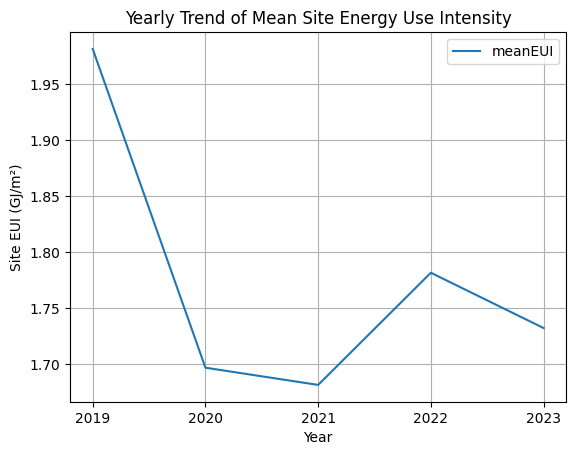

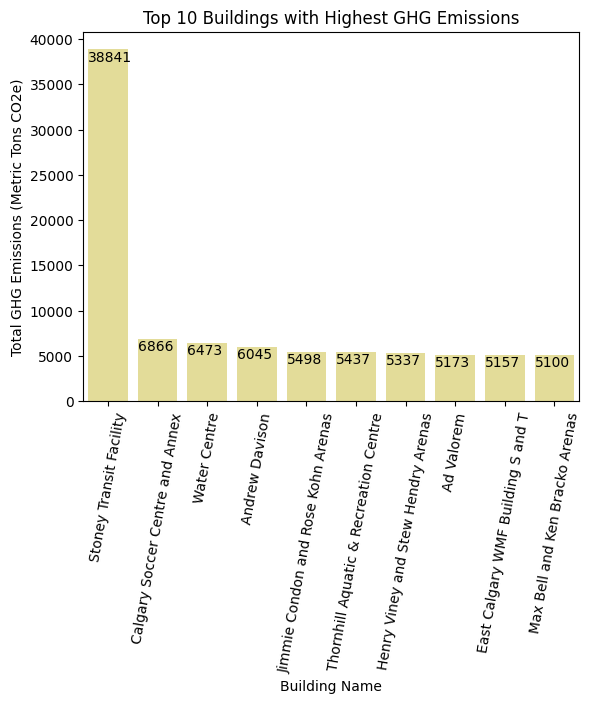

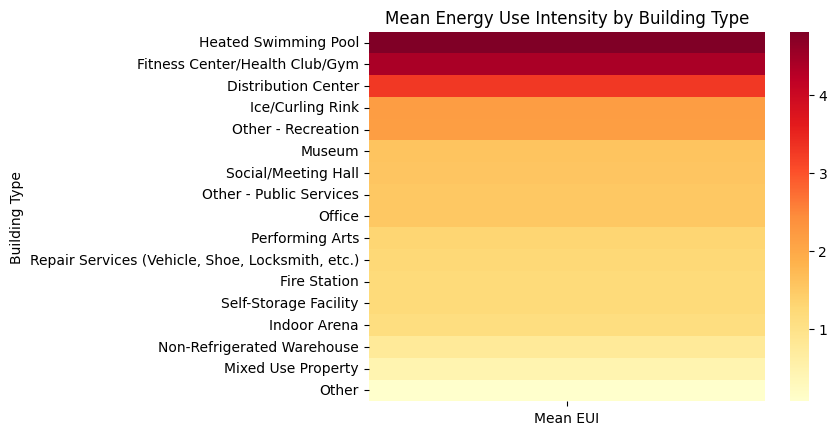

In [149]:
# Part 3

# Yearly trend of mean Site Energy Use Intensity
# The main significant decrease occurred between 2019 and 2020,
# with mean EUI remaining consistent for a year afterwards before
# rising slightly again in 2022.
meanEUIyear = df.groupby('Year Ending').agg(meanEUI=('Site EUI (GJ/m²)', 'mean'))
g1 = sns.lineplot(meanEUIyear)
g1.set_xticks(range(2019, 2024), labels=range(2019, 2024))
g1.set_title('Yearly Trend of Mean Site Energy Use Intensity')
g1.set_xlabel('Year')
g1.set_ylabel('Site EUI (GJ/m²)')
plt.grid()
plt.show()

# Top 10 buildings with highest GHG emissions
sumGHGbuilding = df.groupby('Property Id').agg(totalGHG=('Total GHG Emissions (Metric Tons CO2e)', 'sum'))
t10buildingGHG = sumGHGbuilding.nlargest(10, 'totalGHG')
t10buildingGHG = pd.merge(t10buildingGHG, df[['Property Id', 'Property Name']], on='Property Id', how='left').drop_duplicates()
g2 = sns.barplot(t10buildingGHG, x='Property Name', y='totalGHG', color='khaki')
g2.set_title('Top 10 Buildings with Highest GHG Emissions')
g2.set_xlabel('Building Name')
g2.set_ylabel('Total GHG Emissions (Metric Tons CO2e)')
plt.xticks(rotation=80)
for i in range(len(t10buildingGHG.index)):
    plt.text(i-0.4,t10buildingGHG['totalGHG'].values[i]-1300, int(t10buildingGHG['totalGHG'].values[i]))
plt.show()

# Heatmap of energy usage intensity for each property type
meanEUI.sort_values('meanEUI', ascending=False, inplace=True)
g3 = sns.heatmap(meanEUI, cmap='YlOrRd', annot=False)
g3.set_title('Mean Energy Use Intensity by Building Type')
g3.set_ylabel('Building Type')
g3.set_xticklabels(['Mean EUI'])
plt.show()